Hand-In of Group 13, Jonathan Ehrengruber (jonathan.ehrengruber@students.fhnw.ch), Christian Renold (christian.renold@hslu.ch)

In [1]:
# setup_gpus() function for configuration the gpu on icolab jupyter hub implemented in separate file for reusability
import gpu_init

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPU
GPU Setup done


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import gzip
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import utils

%matplotlib inline

In [3]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

In [4]:
train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)

train_labels = extract_labels('train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)

X_train = train_data.reshape(-1, 28,28, 1)  # add grey channel
X_test = test_data.reshape(-1, 28,28, 1)

n_classes = 10
Y_train = utils.to_categorical(train_labels, n_classes) # 1-hot
Y_test = utils.to_categorical(test_labels, n_classes)
print(Y_train[:10])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [5]:
# Shape of training set
print("Training set (images) shape: {shape}".format(shape=X_train.shape))
# Shape of test set
print("Test set (images) shape: {shape}".format(shape=X_test.shape))
# Type of data - should be float32
print('data type: ', X_train.dtype, X_test.dtype)

Training set (images) shape: (60000, 28, 28, 1)
Test set (images) shape: (10000, 28, 28, 1)
data type:  float32 float32


Text(0.5, 1.0, '(Label: D)')

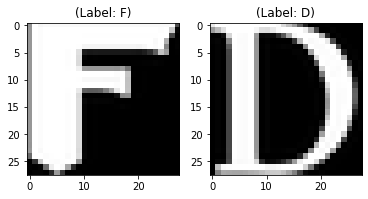

In [6]:
# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(X_train[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(X_test[0], (28,28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [7]:
# rescale the data in range 0-1
X_train = X_train / 255.0
X_test = X_test / 255.0

## Create a shallow MLP encoder

In [8]:
# STARTING FROM HERE, COMPLETE THE CODE WHERE YOU SEE ...
# size of our encoded representation
encoding_dim = 32  # this is the number of neurons you chose to encode

# define input layer, encoded layer and decoded layer
input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

# define autoencoder model 
autoencoder = Model(inputs=input_img, outputs=decoded)
encoder = Model(inputs=input_img, outputs=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [9]:
# compile the network - use adam optimizer, beware to use the good loss function
autoencoder.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [10]:
# for visualisation
def plot_result(x_test,decoded_imgs):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [11]:
X_train_flat = X_train.reshape(60000,784)
X_test_flat = X_test.reshape(10000,784)

In [12]:
noise_factor = 0.4
noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train_flat.shape)
X_train_noisy = X_train_flat + noise
X_train_noisy = np.clip(X_train_noisy, 0.,1.)

noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test_flat.shape)
X_test_noisy = X_test_flat + noise
X_test_noisy = np.clip(X_test_noisy, 0.,1.)

In [13]:
# train the network
log = autoencoder.fit(X_train_flat, X_train_flat, validation_data=(X_test_flat, X_test_flat))

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 7s 116us/sample - loss: 0.0546 - accuracy: 0.0018 - val_loss: 0.0284 - val_accuracy: 0.0010


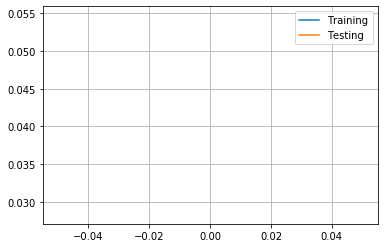

In [14]:
plt.plot(log.history['loss'], label='Training')
plt.plot(log.history['val_loss'], label='Testing')
plt.legend()
plt.grid()

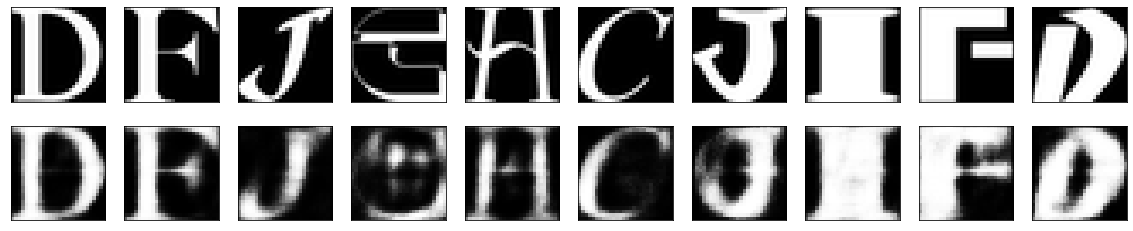

In [15]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(X_test_flat)
decoded_imgs = decoder.predict(encoded_imgs)
plot_result(X_test_flat,decoded_imgs)

### Use the encoded features to train another classifier

In [16]:
X_train_feat = encoder.predict(X_train_flat)
X_test_feat = encoder.predict(X_test_flat)

# Normalization (standardization) of training and test sets
scaler = StandardScaler()  
scaler.fit(X_train_feat)
X_train_feat = scaler.transform(X_train_feat)  
X_test_feat = scaler.transform(X_test_feat)

print(X_train_feat.shape)
print(Y_train.shape)
print(X_test_feat.shape)
print(Y_test.shape)

(60000, 32)
(60000, 10)
(10000, 32)
(10000, 10)


In [17]:
# using the features to train a SVM
clf = SVC(kernel='linear', cache_size=7000)
clf.fit(X_train_feat, train_labels)

SVC(C=1.0, cache_size=7000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [18]:
y_pred = clf.predict(X_test_feat)

# Print classification results with confusion matrix
print("Classification report for classifier %s:\n%s\n" %
      (clf, metrics.classification_report(test_labels, y_pred)))
# print("\nConfusion matrix:\n%s" % metrics.confusion_matrix(test_labels, y_pred))

Classification report for classifier SVC(C=1.0, cache_size=7000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1000
           1       0.89      0.88      0.89      1000
           2       0.90      0.92      0.91      1000
           3       0.92      0.90      0.91      1000
           4       0.91      0.87      0.89      1000
           5       0.88      0.93      0.91      1000
           6       0.89      0.87      0.88      1000
           7       0.90      0.89      0.90      1000
           8       0.88      0.86      0.87      1000
           9       0.86      0.93      0.89      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg

## Create a conv autoencoder

In [28]:
input_img = Input(shape=(28,28,1))
# encoder
conv1 = Conv2D(32, (3, 3), padding='same')(input_img) #28 x 28 x 32
pool1 = MaxPooling2D((2, 2))(conv1) #14 x 14 x 32
conv2 = Conv2D(64, (3, 3), padding='same')(pool1) #14 x 14 x 64
pool2 = MaxPooling2D((2, 2))(conv2) #7 x 7 x 64
conv3 = Conv2D(128, (3, 3), padding='same')(pool2) #7 x 7 x 128 (small and thick)
# decoder
conv4 = Conv2D(128, (3, 3), padding='same')(conv3) #7 x 7 x 128
up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128 (UpSampling2D())
conv5 = Conv2D(64, (3, 3), padding='same')(up1) # 14 x 14 x 64
up2 =  UpSampling2D((2,2))(conv5) # 28 x 28 x 64
decoded = Conv2D(1, (3, 3), padding='same')(up2) # 28 x 28 x 1
# autoencoder
autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 7, 7, 128)         1475

In [31]:
log = autoencoder.fit(X_train, X_train, validation_data=(X_test, X_test), batch_size=128)

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 13s 215us/sample - loss: 0.0215 - accuracy: 0.5932 - val_loss: 0.0195 - val_accuracy: 0.6091


### Predict on test data

In [33]:
decoded_imgs = autoencoder.predict(X_test, verbose=0)
print(decoded_imgs.shape)

(10000, 28, 28, 1)


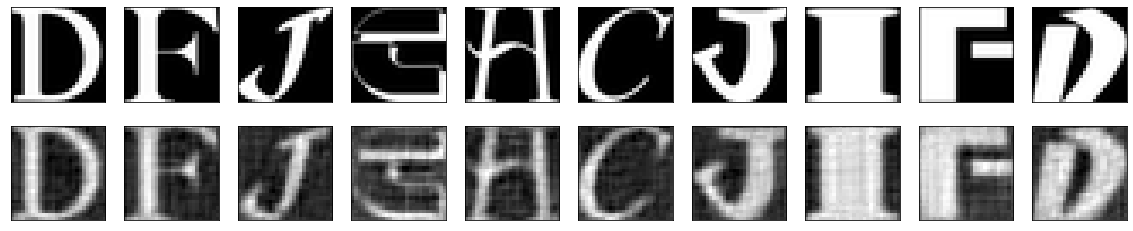

In [34]:
plot_result(X_test_flat,decoded_imgs)

## Denoising autoencoder
First add some noise.

In [35]:
noise_factor = 0.4 #chose a noise factor between 0.0 and 1.0
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

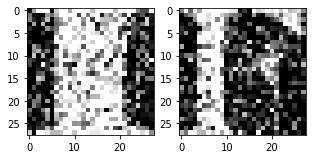

In [36]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(X_train_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(X_test_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

In [37]:
# REDEFINE HERE A CONV AUTOENCODER FOR THE DENOISING WITH A SIMILAR ARCHITECTURE
input_img = Input(shape=(28,28,1))
# encoder
conv1 = Conv2D(32, (3, 3), padding='same')(input_img) #28 x 28 x 32
pool1 = MaxPooling2D((2, 2))(conv1) #14 x 14 x 32
conv2 = Conv2D(64, (3, 3), padding='same')(pool1) #14 x 14 x 64
pool2 = MaxPooling2D((2, 2))(conv2) #7 x 7 x 64
conv3 = Conv2D(128, (3, 3), padding='same')(pool2) #7 x 7 x 128 (small and thick)
# decoder
conv4 = Conv2D(128, (3, 3), padding='same')(conv3) #7 x 7 x 128
up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128 (UpSampling2D())
conv5 = Conv2D(64, (3, 3), padding='same')(up1) # 14 x 14 x 64
up2 =  UpSampling2D((2,2))(conv5) # 28 x 28 x 64
decoded = Conv2D(1, (3, 3), padding='same')(up2) # 28 x 28 x 1
# autoencoder
autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 7, 7, 128)         1475

In [38]:
# train on the noisy images and use as target the original clean images
log = autoencoder.fit(X_train_noisy, X_train, batch_size=128, epochs=1,
                        verbose=1, validation_data=(X_test_noisy, X_test))

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 13s 217us/sample - loss: 0.0539 - accuracy: 0.5786 - val_loss: 0.0314 - val_accuracy: 0.6058


In [39]:
decoded_imgs = autoencoder.predict(X_test_noisy, verbose=0)
print(decoded_imgs.shape)

(10000, 28, 28, 1)


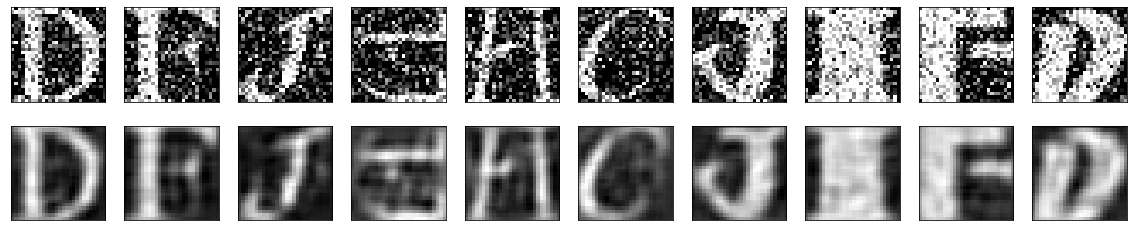

In [40]:
plot_result(X_test_noisy,decoded_imgs)